In [73]:
import os 
import numpy as np
from scipy.signal import convolve2d
import torch
from skimage import io
import galsim
import matplotlib.pyplot as plt

%matplotlib inline

In [65]:
def b3spline_fast(step_hole):
    """This function returns 2D B3-spline kernel for the 'a trou' algorithm.
    INPUT:  step_hole, non-negative integer(number of holes)
    OUTPUT: 2D numpy array """
    step_hole = int(step_hole)
    c1 = 1./16
    c2 = 1./4
    c3 = 3./8
    length = 4*step_hole+1
    kernel1d = np.zeros((1,length))
    kernel1d[0,0] = c1
    kernel1d[0,-1] = c1
    kernel1d[0,step_hole] = c2
    kernel1d[0,-1-step_hole] = c2
    kernel1d[0,2*step_hole] = c3
    kernel2d = np.dot(kernel1d.T,kernel1d)
    return kernel2d

# def soft_thresh(signal, threshold):
#     """This function returns the result of a soft thresholding operation.
#     INPUT: signal, Numpy Array
#            threshold, Numpy Array
#     OUTPUT: res, Numpy Array"""
#     res = np.sign(signal) * (np.abs(signal) - threshold) * (np.abs(signal) >= threshold)
#     return res

# def MS_soft_thresh(wave_coef, n_sigma):
#     """This function returns the result of a multi-scale soft thresholding
#     operation perfromed on wave_coef and using the coefficients of n_sigma as
#     thresholds.
#     INPUT: wave_coef, Numpy Array
#            n_sigma, Numpy Array
#     OUTPUT: wave_coef_rec_MS, Numpy Array"""
#     wave_coef_rec_MS = np.zeros(wave_coef.shape)
#     for i,wave in enumerate(wave_coef):
#         # Denoise image
#         wave_coef_rec_MS[i,:,:] = soft_thresh(wave, n_sigma[i])
#     return wave_coef_rec_MS

def star2d(im,scale,gen2=True):
    """This function returns the starlet transform of an image.
    INPUT:  im, 2D numpy array
            scale, positive integer (number of scales)
            gen2, boolean (to select the starlets generation)
    OUTPUT: 3D numpy array """
    (nx,ny) = np.shape(im)
    nz = scale
    wt = np.zeros((nz,nx,ny))
    step_hole = 1
    im_in = np.copy(im)

    for i in np.arange(nz-1):
        kernel2d = b3spline_fast(step_hole)
        im_out = convolve2d(im_in, kernel2d, boundary='symm',mode='same')

        if gen2:
            im_aux = convolve2d(im_out, kernel2d, boundary='symm',mode='same')
            wt[i,:,:] = im_in - im_aux
        else:        
            wt[i,:,:] = im_in - im_out

        im_in = np.copy(im_out)
        step_hole *= 2

    wt[nz-1,:,:] = np.copy(im_out)

    return wt

def istar2d(wtOri,gen2=True):
    """This function reconstructs the image from its starlet transformation.
    INPUT:  wtOri, 3D numpy array
            gen2, boolean (to precise the starlets generation)
    OUTPUT: 3D numpy array """
    (nz,nx,ny) = np.shape(wtOri)
    wt = np.copy(wtOri)
    if gen2:
        '''
        h' = h, g' = Dirac
        '''
        step_hole = pow(2,nz-2)
        imRec = np.copy(wt[nz-1,:,:])
        for k in np.arange(nz-2,-1,-1):
            kernel2d = b3spline_fast(step_hole)
            im_out = convolve2d(imRec, kernel2d, boundary='symm',mode='same')
            imRec = im_out + wt[k,:,:]
            step_hole /= 2            
    else:
        '''
        h' = h, g' = Dirac + h
        '''
        imRec = np.copy(wt[nz-1,:,:])
        step_hole = pow(2,nz-2)
        for k in np.arange(nz-2,-1,-1):
            kernel2d = b3spline_fast(step_hole)
            imRec = convolve2d(imRec, kernel2d, boundary='symm',mode='same')
            im_out = convolve2d(wt[k,:,:], kernel2d, boundary='symm',mode='same')
            imRec += wt[k,:,:]+im_out
            step_hole /= 2
            
    return imRec

def PSNR(img1, img2, normalize=True):
    """Calculate the PSNR of two images."""
    if not img1.shape == img2.shape:
        raise('Images have inconsistent Shapes!')

    img1 = np.array(img1)
    img2 = np.array(img2)

    if normalize:
        img1 = (img1 - img1.min())/(img1.max() - img1.min())
        img2 = (img2 - img2.min())/(img2.max() - img1.min())
        PIXEL_MAX = 1.0
    else:
        PIXEL_MAX = np.max([img1.max(), img2.max()])

    MSE = ((img1 - img2)**2).mean()
    psnr = 20*np.log10(PIXEL_MAX/np.sqrt(MSE))

    return psnr

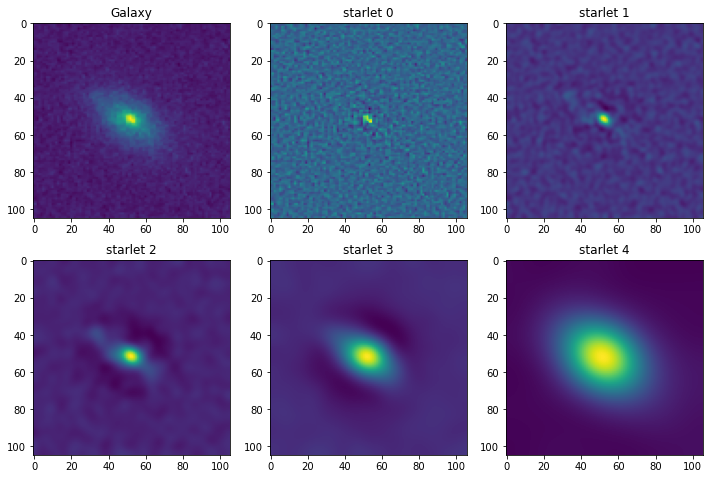

In [66]:
COSMOS_dir = './data/COSMOS_23.5_training_sample/'
idx = 1435
scale = 5
real_galaxy_catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))
gal_image = real_galaxy_catalog.getGalImage(idx).array
wt = star2d(gal_image, scale=scale)

plt.figure(figsize=(12,8))
for i in range(0,scale+1):
    plt.subplot(2,3,i+1)
    if i==0:
        plt.imshow(gal_image)
        plt.title('Galaxy')
    else:
        plt.imshow(wt[i-1])
        plt.title(f"starlet {i-1}")
plt.show()

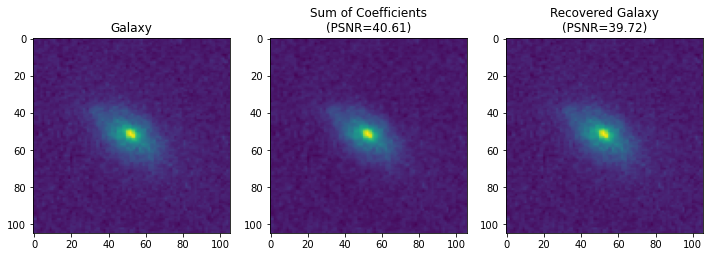

In [67]:
gal_rec = istar2d(wt)

plt.figure(figsize=(12,9))
plt.subplot(1,3,1)
plt.imshow(gal_image)
plt.title('Galaxy')
plt.subplot(1,3,2)
plt.imshow(wt.sum(axis=0))
plt.title('Sum of Coefficients\n(PSNR={:.2f})'.format(PSNR(gal_image, wt.sum(axis=0))))
plt.subplot(1,3,3)
plt.imshow(gal_rec)
plt.title('Recovered Galaxy\n(PSNR={:.2f})'.format(PSNR(gal_image, gal_rec)))
plt.show()

In [72]:
print(np.linalg.norm(gal_image,ord=1), np.linalg.norm(gal_rec,ord=1))
print(wt[3].max(), wt[3].min())

1.7963118187908549 1.7963118187908549
0.03759104686326657 -0.00580592859981055
